In [58]:
import JensenTools as JT
from lmfit import Model
import PyCrystalField as cef
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import seaborn
seaborn.set()


#Simple function for pritting fitted params so that I can copy paste the values from output
def paramPrint(fittedparams):
	print()
	for i in fittedparams:
		# print(i, ' = ', i.value)
		print(i, ' = ',fittedparams[i].value )

##  My Energy Calculation Function To Be Used As An LMFIT Model

In [59]:
#energy level calculation used with LMFIT.
#calculates 4 energies, the eigenvalues as given by PCF
#Returns 3 energies (chosen because we only have 3 observed modes from INS) as well as a ratio of the 3rd energy to the 2nd energy.
#this ratio comes from the fact that those two are visible in one Ei from INS. It was thought that it may improve fitting, but ultimately doesn't change result
def energyCalcKFit(B40,B60,LS, numlevels, B44, B64, B20):
	numlevels = numlevels
	Stev = {}
	Stev['B20'] = B20
	Stev['B40'] = B40
	Stev['B60'] = B60
	Stev['B44'] = B44
	Stev['B64'] = B64

	Pr = cef.LS_CFLevels.Bdict(Bdict=Stev, L=3, S=0.5, SpinOrbitCoupling=LS)
	Pr.diagonalize()
	e = JT.kmeansSort(Pr.eigenvalues,numlevels)[:3]
	e.append(e[2]/e[1])
	return e

## L and S values for our ion, energy levels as measured by INS, and Stevens' Starting Point From Grid Search

In [60]:
L = 3
S = 0.5
Emeas = [168, 335,385,385/335]


#Groundstate quartet from grid search
#####################################################################################################################################################################
# LS = 60
# x = 0.1489
# bpf = 0.1214
#####################################################################################################################################################################


#Groundstate doublet from grid search
#####################################################################################################################################################################
LS = 100
x =  0.03629536921151444
bpf = -0.6570713391739674
#####################################################################################################################################################################


#Starting point from grid search
#####################################################################################################################################################################
B40 = bpf
B60 = x*bpf
B44 = 5*B40
B64 = -21*B60
B20 = 0
#####################################################################################################################################################################


## LMFIT Model Creation

In [61]:
#Create the LMFIT model using my energy calc function
#Let all values be dependent params except for number of levels
#We can aleways lock or unlock the varying of each param (making them effectively independent/dependent)
eModel = Model(energyCalcKFit, independent_vars = ['numlevels'])
params = eModel.make_params()


## Uncomment below to make sure the proper variables are set
# print('parameter names: {}'.format(eModel.param_names))
# print('independent variables: {}'.format(eModel.independent_vars))


## Various fitting results 

In [62]:
#LS = 60 after first fit
#####################################################################################################################################################################
# B40  =  0.12180061444410276
# B60  =  0.01834786369041378
# LS  =  57.45
# B44  =  0.5374
# B64  =  -0.4043
# B20  =  7.510061514065815e-09
#####################################################################################################################################################################

# LS = 100 after first fit
#####################################################################################################################################################################
# B40  =  -0.6570713391739674
# B60  =  -0.023848646853623378
# LS  =  100
# B44  =  -3.154140963392758
# B64  =  0.504906552605772
# B20  =  0.529084119465899

#second fit
# B40  =  -0.6570713391739674
# B60  =  -0.023848646853623378
# LS  =  100
# B44  =  -3.154140963392758
# B64  =  0.504906552605772
# B20  =  0.529084119465899

#third fit
# B40  =  -0.6570718365345304
# B60  =  -0.02385271036348989
# LS  =  100.00007580463522
# B44  =  -3.154140963392758
# B64  =  0.504906552605772
# B20  =  0.5295279160565758

#fourth fit
B40  =  -0.6568663783690575
B60  =  -0.02328250024945387
LS  =  100.00007580463522
B44  =  -3.1415463304732714
B64  =  0.504906552605772
B20  =  0.4858075931009187
#####################################################################################################################################################################

## Set the parameters and fit

In [63]:
#Fitting with LMFIT
#####################################################################################################################################################################
params['B20'].set(value = B20, vary = True)
params['B40'].set(value=B40, vary=True)
params['B60'].set(value=B60, vary=True)
params['B44'].set(value = B44, vary = True )
params['B64'].set(value = B64, vary = False )
params['LS'].set(value=LS, vary=False)

#Fit model to data
fitted = eModel.fit(Emeas,params, numlevels = 4)

#Print the parameters and reduced chi sqr value
print('\n\nFitted parameters:')
fitted.params.pretty_print()
print('\nReduced Chi Sqr = {}'.format(fitted.result.redchi))

#Uncomment to print out in easy copy paste format
# paramPrint(fitted.params)



Fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
B20    0.4858     -inf      inf    2.807     True     None     None
B40   -0.6569     -inf      inf   0.1477     True     None     None
B44    -3.142     -inf      inf   0.7763     True     None     None
B60  -0.02328     -inf      inf 0.0005579     True     None     None
B64    0.5049     -inf      inf        0    False     None     None
LS        100     -inf      inf        0    False     None     None

Reduced Chi Sqr = 1.0938623389075575


## Use our fitted B parameters to obtain the CF Hamiltonian

In [64]:
#Create a dictionary of the fitted parameters (stevens coefficients)
stev = {'B40': fitted.params['B40'].value, 'B60': fitted.params['B60'].value, 'B44' : fitted.params['B44'].value, 'B64' : fitted.params['B64'].value, 'B20' :fitted.params['B20'].value }

#Create the CFLevels object and diagonalize it
Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=fitted.params['LS'].value)
Pr.diagonalize()

#Print final matrix
print('\n\nEnergy values as measured by INS (meV): {}'.format(Emeas))
Pr.printEigenvectors()


# Pr.printLaTexEigenvectors()





Energy values as measured by INS (meV): [168, 335, 385, 1.1492537313432836]

 Eigenvalues 	 Eigenvectors
		---------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.     0.     0.     0.     0.    -0.706  0.706  0.     0.     0.
  0.     0.     0.    -0.055]  |
0.00000 	|  [ 0.055  0.     0.     0.     0.     0.     0.    -0.706  0.706  0.
  0.     0.     0.     0.   ]  |
14.68320 	|  [ 0.     0.     0.    -0.3    0.277  0.     0.     0.     0.     0.
  0.    -0.302  0.862  0.   ]  |
14.68320 	|  [ 0.    -0.862  0.302  0.     0.     0.     0.     0.     0.    -0.277
  0.3    0.     0.     0.   ]  |
167.99998 	|  [ 0.     0.48   0.244  0.     0.     0.     0.     0.     0.    -0.654
  0.531  0.     0.     0.   ]  |
167.99998 	|  [ 0.     0.     0.     0.531 -0.654  0.     0.     0.     0.     0.
  0.     0.244  0.48   0.   ]  |
335.00000 	|  [ 0.     0.     0.     0.     0.    -0.581 -0.623  0.     0.     0.
  0.     0.  

## PCF G Tensor

In [65]:
#Calculate and neatly print G-Tensor using Pandas
gt = Pr.gtensor()
rows = ['gx','gy','gz']
df = pd.DataFrame(gt, columns = rows, index = rows)
print(df)

                            gx                          gy                  gz
gx  8.311543e-01+0.000000e+00j  0.000000e+00-5.551115e-17j  0.000000+0.000000j
gy  0.000000e+00+5.551115e-17j  8.311543e-01+0.000000e+00j  0.000000+0.000000j
gz  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j  0.995669+0.000000j


## PCF Magnetization

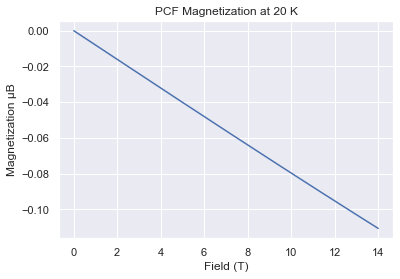

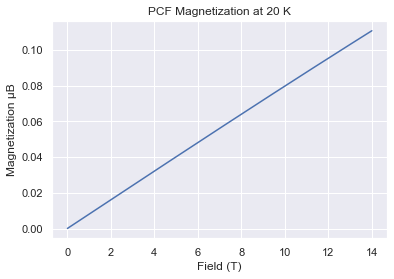

In [66]:
#Generate a magnetization curve for comparing results to experiment
magCalc = []
fieldT = np.linspace(0.01,14,1000)
Temp = 20
for i in fieldT:
	magCalc.append(Pr.magnetization( Temp = Temp, Field = [0, 0, i])[2])
# print(magCalcx[-1]) #prints final value at 14T

plt.plot(fieldT,magCalc)
plt.xlabel('Field (T)')
plt.ylabel('Magnetization \N{GREEK SMALL LETTER MU}B')
plt.title('PCF Magnetization at {} K'.format(Temp))

plt.figure()
plt.plot(fieldT,-1.*np.array(magCalc))
plt.xlabel('Field (T)')
plt.ylabel('Magnetization \N{GREEK SMALL LETTER MU}B')
plt.title('PCF Magnetization at {} K'.format(Temp))
plt.show()

## PCF Susceptibility

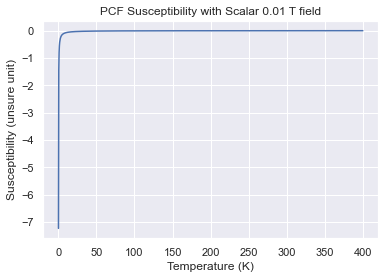

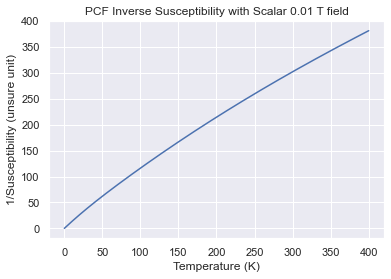

In [67]:
suscCalc = []
Temp = np.linspace(.1,400,1000)
fieldT = 0.01
deltaField = 0.0001
suscCalc = Pr.susceptibility(Temps = Temp, Field = fieldT, deltaField = deltaField)
# for i in Temp:
	# suscCalc.append(Pr.susceptibility(i,fieldT,deltaField))

suscCalcI = []
for i in suscCalc:
	suscCalcI.append(-1/i)
plt.figure()
plt.plot(Temp,suscCalc)
plt.xlabel('Temperature (K)')
plt.ylabel('Susceptibility (unsure unit)')
plt.title('PCF Susceptibility with Scalar {} T field'.format(fieldT))

plt.figure()
plt.plot(Temp,suscCalcI)
plt.xlabel('Temperature (K)')
plt.ylabel('1/Susceptibility (unsure unit)')
plt.title('PCF Inverse Susceptibility with Scalar {} T field'.format(fieldT))
plt.show()

## PCF Neutron Spectrum

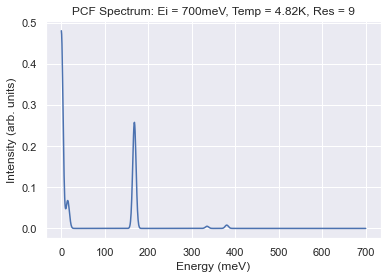

In [68]:
energy = np.linspace(.01,700,1000)
Ei = 700
Temp = 4.82
res = 9

CalculatedSpectrum = Pr.neutronSpectrum(energy, Temp=Temp, Ei=Ei, ResFunc = lambda x: res )
# ResFunc = lambda x: 9 if (energy < 200) else 21
plt.figure()
plt.plot(energy,CalculatedSpectrum)
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Energy (meV)')
plt.title('PCF Spectrum: Ei = {}meV, Temp = {}K, Res = {}'.format(Ei,Temp,res))
plt.show()

## Convert our fitted Stevens' to Wybourne

In [69]:
# wyb = cef.StevensToWybourne('Ce3+',stev, LS=True)
# print(wyb)